In [1]:
# Aqui neste código ##

## 1. Criação de tabela única 
## 2. Retirar duplicatas
## 3. Análise das string nulas e valores nulos
## 4. Análise exploratória
## 5. Time Series - ARIMA Modelo Original
## 6. Time Series - ARIMA Modelo com transformação logarítmica
## 7. Time Series - SARIMA Modelo Original
## 8. Time Series - SARIMA Modelo com transformação logarítmica
## 9. Time Series - SARIMA Modelo Original para notas acima de 3

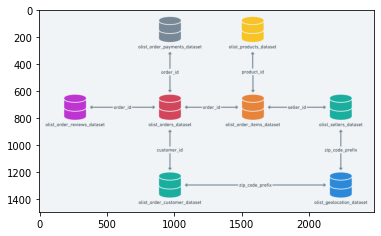

<Figure size 720x864 with 0 Axes>

In [2]:
## Plot do schema

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('data_schema.png')
imgplot = plt.imshow(img)
plt.figure(figsize=(10, 12))
plt.show()

In [3]:
## Plot do schema

from PIL import Image                                                                                
img = Image.open('data_schema.png')
img.show() 

In [4]:
## Carregando as bases

olist_customers_dataset = pd.read_csv("olist_customers_dataset.csv") ## Base em que temos a informação de recompra;
olist_geolocation_dataset = pd.read_csv("olist_geolocation_dataset.csv") ## Base com informação de latitude e longitude. Por hora, não será necessária;
olist_order_items_dataset = pd.read_csv("olist_order_items_dataset.csv") ## Base em que temos a informação de preço em que será utilizada para o forecasting;
olist_order_payments_dataset = pd.read_csv("olist_order_payments_dataset.csv")  ## Base com informação de método de pagamento. Por hora, não será necessária;
olist_order_reviews_dataset = pd.read_csv("olist_order_reviews_dataset.csv") ## Base em que temos o score de cada review;
olist_orders_dataset = pd.read_csv("olist_orders_dataset.csv") ## Base em que temos a chave order_id;
olist_products_dataset = pd.read_csv("olist_products_dataset.csv") ## Base em que temos especificações do produto (ex: tamanho). Por hora, não será necessária;
olist_sellers_dataset = pd.read_csv("olist_sellers_dataset.csv") ## Base em que temos especificações da localização do seller. Por hora, não será necessária;
product_category_name_translation = pd.read_csv("product_category_name_translation.csv") ## Base que traduz a categoria do produto para inglês. Por hora, não será necessária;


## Na análise, só serão utilizadas 4 bases de dados: olist_customers_dataset, olist_order_items_dataset, olist_orders_dataset e olist_order_reviews_dataset.

In [5]:
## Criação de tabela única

df = {}

df = pd.merge(olist_orders_dataset, olist_customers_dataset, on='customer_id', how='left')
df = pd.merge(df, olist_order_reviews_dataset, on='order_id', how='left')
df = pd.merge(df, olist_order_items_dataset, on='order_id', how='left')


In [6]:
## Conferindo informações da tabela única

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114092 entries, 0 to 114091
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       114092 non-null  object 
 1   customer_id                    114092 non-null  object 
 2   order_status                   114092 non-null  object 
 3   order_purchase_timestamp       114092 non-null  object 
 4   order_approved_at              113930 non-null  object 
 5   order_delivered_carrier_date   112112 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  114092 non-null  object 
 8   customer_unique_id             114092 non-null  object 
 9   customer_zip_code_prefix       114092 non-null  int64  
 10  customer_city                  114092 non-null  object 
 11  customer_state                 114092 non-null  object 
 12  review_id                     

In [7]:
## Análise dos dados duplicados

df[df.duplicated()>0]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value


In [8]:
## Analisando NaN values

pd.set_option('display.max_rows', None)
missing_values = pd.concat([df.isna().sum().sort_values(ascending = False)], axis=1, keys=['Total'])
missing_values

,Total
review_comment_title,100569
review_comment_message,65926
order_delivered_customer_date,3253
order_delivered_carrier_date,1980
review_id,961
review_score,961
review_answer_timestamp,961
review_creation_date,961
price,778
shipping_limit_date,778


In [9]:
## Temos 8 erros em que objetos entregues não tem data

df[df['order_delivered_customer_date'].isna()].order_status.value_counts()


shipped        1197
canceled        704
unavailable     612
invoiced        366
processing      358
delivered         8
created           5
approved          3
Name: order_status, dtype: int64

In [10]:
## Temos 2 erros em que objetos postados deveriam estar com data de postagem

df[df['order_delivered_carrier_date'].isna()].order_status.value_counts()

canceled       634
unavailable    612
invoiced       366
processing     358
created          5
approved         3
delivered        2
Name: order_status, dtype: int64

In [11]:
## Análise de 778 linhas com product_id, Seller_id e price nulos

df[df['seller_id'].isna()].order_status.value_counts()


unavailable    605
canceled       165
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [12]:
## Pedidos com seller_id zerado são produtos que geralmente foram comprados e não têm em estoque. Alguns foram cancelados e a empresa registra como seller_id nulo, product_id nulo, price nulo, como se a compra nunca tivesse sido realizada
## Percebi lendo alguns comentários que, para produtos sem estoque (marcados como unavailable) o cliente paga, não recebe e nem sequer é notificado 

df[df['seller_id'].isna()]


## Revisão teórica - é preciso analisar o impacto da relação oferta-demanda para os modelos de previsão de vendas

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
306,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00,41fc647b8c6bd979b1b6364b60471b50,89288,...,NaN,Anunciam um produto que não tem em estoque e a...,2017-12-07 00:00:00,2017-12-11 10:37:57,NaN,NaN,NaN,NaN,NaN,NaN
673,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00,0e634b16e4c585acbd7b2e8276ce6677,11701,...,NaN,NaN,2018-02-18 00:00:00,2018-02-20 19:23:56,NaN,NaN,NaN,NaN,NaN,NaN
798,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00,596ed6d7a35890b3fbac54ec01f69685,2318,...,NaN,Até hoje não recebi meu produto e nem uma resp...,2017-09-10 00:00:00,2017-09-12 17:00:15,NaN,NaN,NaN,NaN,NaN,NaN
857,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00,2349bbb558908e0955e98d47dacb7adb,48607,...,NaN,Não compre,2018-02-09 00:00:00,2018-02-09 03:22:43,NaN,NaN,NaN,NaN,NaN,NaN
1304,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,4fa4365000c7090fcb8cad5713c6d3db,1151,...,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN
1337,2f634e2cebf8c0283e7ef0989f77d217,7353b0fb8e8d9675e3a704c60ca44ebe,unavailable,2017-09-27 20:55:33,2017-09-28 01:32:50,NaN,NaN,2017-10-27 00:00:00,21c933c8dd97d088e64c50988c90ccf5,5017,...,NaN,"Comprei um perfume Bleu de Chanel , paguei e n...",2017-10-29 00:00:00,2017-10-29 16:40:21,NaN,NaN,NaN,NaN,NaN,NaN
1814,ee0db22a8e742b752914016708470ec8,aae50600d30bf2efe013ca4c1754ded7,unavailable,2017-08-24 11:04:41,2017-08-24 11:15:11,NaN,NaN,2017-09-18 00:00:00,bdc67efa33dd0c3228b91714ac6e363c,23027,...,NaN,"voces se tornaram corruptos,paguei e ainda nao...",2017-09-20 00:00:00,2017-10-10 21:22:12,NaN,NaN,NaN,NaN,NaN,NaN
2054,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00,08642cd329066fe11ec63293f714f2f8,33030,...,NaN,O produto veio com defeito ele não liga não fu...,2018-07-28 00:00:00,2018-07-30 11:06:16,NaN,NaN,NaN,NaN,NaN,NaN
2088,6ad57aecbae806a7e9cc2cdb6b380711,d31dbd02ac052d662285f678f8994326,unavailable,2017-11-30 07:48:24,2017-11-30 08:14:42,NaN,NaN,2017-12-29 00:00:00,45b1948a7554a397cc42c2ea55c54ab6,18207,...,NaN,Estou esperando até agora a entrega do produto...,2017-12-31 00:00:00,2017-12-31 13:00:06,NaN,NaN,NaN,NaN,NaN,NaN
2135,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00,c219f4ac1bc7f1aea33e6ab8885831e8,68742,...,NaN,Razoável,2017-04-12 00:00:00,2017-04-12 14:18:26,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
## Sobre os canceled com seller_id nulo: produto errado, com defeito ou não chegou

df[(df['seller_id'].isna()) & (df['order_status']=='canceled')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
1304,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00,4fa4365000c7090fcb8cad5713c6d3db,1151,...,Entregaram produto errado,Comprei dois fones de ouvido com valor de R$ 5...,2018-08-28 00:00:00,2018-08-28 18:25:55,NaN,NaN,NaN,NaN,NaN,NaN
2054,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00,08642cd329066fe11ec63293f714f2f8,33030,...,NaN,O produto veio com defeito ele não liga não fu...,2018-07-28 00:00:00,2018-07-30 11:06:16,NaN,NaN,NaN,NaN,NaN,NaN
2135,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00,c219f4ac1bc7f1aea33e6ab8885831e8,68742,...,NaN,Razoável,2017-04-12 00:00:00,2017-04-12 14:18:26,NaN,NaN,NaN,NaN,NaN,NaN
2324,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00,a8dd81392e5eee5d979c629a76abec2a,13059,...,Adorei,NaN,2018-08-26 00:00:00,2018-08-26 20:21:38,NaN,NaN,NaN,NaN,NaN,NaN
2473,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00,29dc4aeff866d6a940c471a3ea4faef0,5752,...,NaN,NaN,2017-06-01 00:00:00,2017-06-01 08:21:44,NaN,NaN,NaN,NaN,NaN,NaN
3454,ddaec6fff982b13e7e048b627a11d6da,68f4ad79cc0c2ad06e19088f5c00e9fa,canceled,2016-10-04 19:41:32,NaN,NaN,NaN,2016-11-16 00:00:00,00f0b70fdcb8a6e1671b52a2472bd41f,5362,...,NaN,"Nunca chegou o produto, deram uma excusa e tro...",2016-11-20 00:00:00,2016-11-20 12:49:39,NaN,NaN,NaN,NaN,NaN,NaN
3498,5290c34bd38a8a095b885f13958db1e1,92af427e290117f39d9ff908566072e0,canceled,2018-08-21 10:25:18,NaN,NaN,NaN,2018-09-06 00:00:00,e61f0f032bc92cadf0ec55f9c1c8b5ec,13848,...,3,NaN,2018-08-18 00:00:00,2018-08-21 00:47:13,NaN,NaN,NaN,NaN,NaN,NaN
4159,03310aa823a66056268a3bab36e827fb,25dbbf0c477fd4ae0880aaffbb12e8b3,canceled,2018-08-07 16:33:59,NaN,NaN,NaN,2018-09-04 00:00:00,46450c74a0d8c5ca9395da1daac6c120,88034,...,Produto errado,Entrega do produto diferente do solicitado\r\n...,2018-08-03 00:00:00,2018-08-06 00:09:52,NaN,NaN,NaN,NaN,NaN,NaN
4955,4c8b9947280829d0a8b7e81cc249b875,403c35c4d8813bf67b3d396b91ca1619,canceled,2018-08-09 14:54:47,NaN,NaN,NaN,2018-08-21 00:00:00,391d6062da3dd65b4de4524f28c478de,3461,...,Anúncio ambíguo dá errado,"Lentes de contato são positivas, para hipermet...",2018-08-02 00:00:00,2018-08-03 01:34:51,NaN,NaN,NaN,NaN,NaN,NaN
5590,b13ea375fe9c728832688264638f84cf,0dc5884bc5ffba283678229f27e07ff9,canceled,2018-08-22 18:52:29,NaN,NaN,NaN,2018-09-19 00:00:00,9075f7211578ba5165cbd7fb49947eba,13045,...,NaN,NaN,2018-08-21 00:00:00,2018-08-22 00:07:01,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
## Análise 1: Existe correlação entre pedidos atrasados e nota atribuída?
## a. Analisar dentre os pedidos atrasados, quantos receberam nota menor ou igual a 3
## b. Analisar dentre os pedidos não atrasados, quantos receberam nota maior do que 3
## c. Analisar se existe correlação linear entre quantidade de dias de demora na entrega e nota

In [15]:
## Criação de um subset para análise

df2={}
df2 = pd.DataFrame().assign(order_id=df['order_id'], order_delivered_customer_date=df['order_delivered_customer_date'], order_estimated_delivery_date = df['order_estimated_delivery_date'], review_score =df['review_score'])
df2.head()

## Vamos excluir os NaN values

df2.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df2.drop_duplicates(subset=['order_id'], inplace=True)

In [16]:
import datetime
import numpy as np

## Transformando os dados de datetime para timestamp

df2['order_delivered_customer_date_transformed'] = pd.to_datetime(df2['order_delivered_customer_date'])
df2['order_delivered_customer_date_transformed'] = df2.order_delivered_customer_date_transformed.values.astype(np.int64) // 10 ** 9
df2['order_delivered_customer_date_transformed'].head()

df2['order_estimated_delivery_date_transformed'] = pd.to_datetime(df2['order_estimated_delivery_date'])
df2['order_estimated_delivery_date_transformed'] = df2.order_estimated_delivery_date_transformed.values.astype(np.int64) // 10 ** 9
df2['order_estimated_delivery_date_transformed'].head()

## Calculando a diferença entre o tempo estimado e o tempo de chegada do pedido. Nos casos negativos, o pedido atrasou.


df2['estimated_minus_delivered'] = df2['order_estimated_delivery_date_transformed']-df2['order_delivered_customer_date_transformed']


1.0    3539
5.0    1703
4.0     946
3.0     871
2.0     603
Name: review_score, dtype: int64

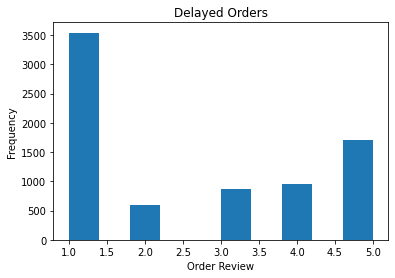

In [17]:
## 65% dos pedidos que atrasam recebem notas menores do que 3

df2_delayed = df2[df2['estimated_minus_delivered']<0]

import matplotlib.pyplot as plt

plt.title('Delayed Orders')
plt.xlabel('Order Review')
plt.ylabel('Frequency')
plt.hist(df2_delayed['review_score'])

df2_delayed['review_score'].value_counts()

5.0    55055
4.0    17947
3.0     7038
1.0     5808
2.0     2320
Name: review_score, dtype: int64

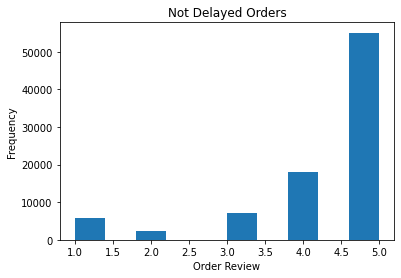

In [18]:
## 83% dos pedidos que não atrasaram receberam nota boa (>=4)

df2_not_delayed = df2[df2['estimated_minus_delivered']>=0]

import matplotlib.pyplot as plt

plt.title('Not Delayed Orders')
plt.xlabel('Order Review')
plt.ylabel('Frequency')
plt.hist(df2_not_delayed['review_score'])

df2_not_delayed['review_score'].value_counts()

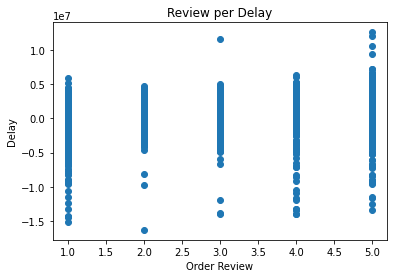

In [19]:
## Não existe relação linear entre quantidade de dias de demora na entrega e nota

plt.scatter(df2['review_score'], df2['estimated_minus_delivered'])
plt.title('Review per Delay')
plt.xlabel('Order Review')
plt.ylabel('Delay')
plt.show()

In [20]:
## Análise 2: Os clientes que dão melhor nota são os clientes que voltam à comprar na Olist?
## a. Analisar dos que recompraram, quantos deram notas boas
## b. Analisar dos que não recompraram, quantos deram notas ruins

In [21]:
## Criação de um subset para análise

df3 = {}
df3 = pd.DataFrame().assign(order_id=df['order_id'], customer_unique_id=df['customer_unique_id'], review_score =df['review_score'])
df3.head()


## Vamos excluir os NaN values

df3.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df3.drop_duplicates(subset=['order_id'], inplace=True)

## Criando a coluna de recompra. Caso True, o cliente recomprou na loja Olist

df3['repurchase'] = df3['customer_unique_id'].duplicated()

In [22]:
## Dos que recompraram, temos notas boas (>=4) em 79% dos casos

df3_repurchase_view = df3[df3['repurchase']>0]

df3_repurchase_view['review_score'].value_counts()

5.0    2026
4.0     566
1.0     363
3.0     251
2.0      87
Name: review_score, dtype: int64

In [23]:
## Dos que não recompraram, temos notas boas (>4) em 77% dos casos

df3_not_repurchase_view = df3[df3['repurchase']<=0]

df3_not_repurchase_view['review_score'].value_counts()

#A hipótese é de que o volume de recompra é pequeno (Cerca de 3,3% dentre todo o universo) e, portanto, a análise pode ser inconclusiva devido ao espaço amostral.

## Se olharmos para o setor da olist, temos uma concorrência acirrada. A Olist está interessada em fidelizar os clientes ou está apenas competindo no preço? Entender o objeto (Ver teoria de concorrência perfeita)

5.0    54993
4.0    18478
1.0    10990
3.0     7873
2.0     3046
Name: review_score, dtype: int64

In [24]:
## Análise 3: Nuvem de palavras para as notas consideradas ruins 

In [25]:
df5 = {}
df5 = pd.DataFrame().assign(order_id=df['order_id'], review_score =df['review_score'], review_comment_message=df['review_comment_message'])
df5.head()


## Vamos excluir os NaN values

df5.dropna(inplace=True)

## Agora vamos considerar apenas a primeira linha que tiver order_id

df5.drop_duplicates(subset=['order_id'], inplace=True)


## Agora vamos filtrar apenas os comentários de nota baixa

df5_neg_review = df5[df5.review_score<=3]['review_comment_message']
df5_pos_review = df5[df5.review_score>3]['review_comment_message']

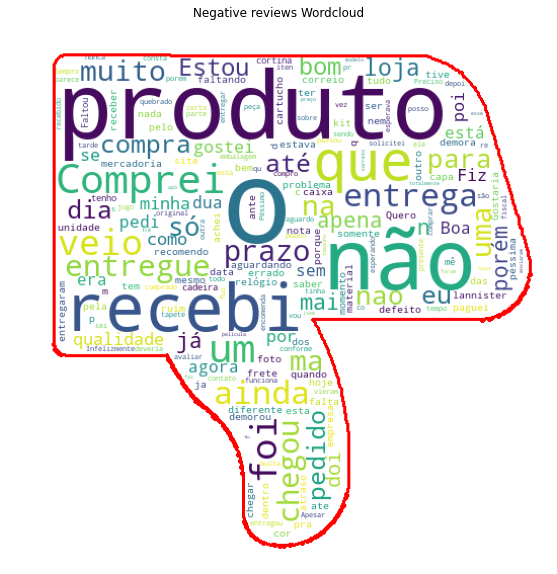

In [26]:
import numpy as np
from PIL import Image
import urllib
from io import BytesIO
import requests
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS


# Palavras a serem desconsideradas da análise
stopwords = set(STOPWORDS)
stopwords.update(["/n" ,"da", "meu", "em", "você", "de", "ao", "os", "e", 'ou', 'é'])
 

def open_img(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img_np = np.array(img)
    return img_np

mask = open_img('https://cdn-images-1.medium.com/max/537/1*CK7ulJRe6nqeorManOJUzg.png')


## Gerando a nuvem de palavras
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Reds', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Red',
                      collocations=False, 
                      repeat = False,                   
                      width=700, height=700).generate(df5_neg_review.to_string(index=False))
 
## Configurando visualização da imagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
## Plotando a imagem
plt.title('Negative reviews Wordcloud')
plt.imshow(wordcloudInst)

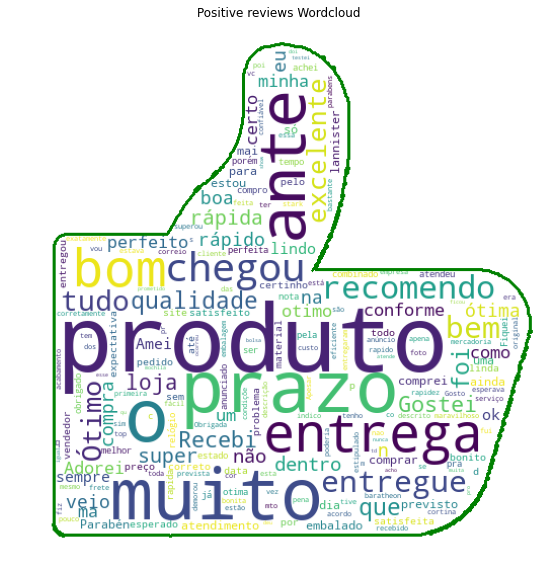

In [27]:
mask = open_img("https://cdn-images-1.medium.com/max/537/1*q4vrNnlsX_d4glglS35AGw.png")


## Gerando a nuvem de palavras
wordcloudInst = WordCloud(stopwords=stopwords,
                      background_color="white",
                      random_state=1,
                    #   colormap='Greens', 
                      mask=mask,
                      contour_width=2, 
                      contour_color='Green',  
                      collocations=False, 
                      repeat = False,    
                      width=700, height=700).generate(df5_pos_review.to_string(index=False))
 
## Configurando visualização da imagem
fig, ax = plt.subplots(figsize=(20,10))
ax.imshow(wordcloudInst, interpolation='bilinear')
ax.set_axis_off()
 
## Plotando a imagem
plt.title('Positive reviews Wordcloud')
plt.imshow(wordcloudInst)

In [28]:
## Análise 4: Forecasting

In [29]:
## Criando o dataset

df4 = {}
df4 = pd.DataFrame().assign(order_purchase_timestamp=df['order_purchase_timestamp'], price=df['price'], review_score=df['review_score'])
df4.head()

## Transformando de datetime para date

df4['order_purchase_timestamp'] = pd.to_datetime(df4['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df4['order_purchase_timestamp'].dtype

df4['order_purchase_timestamp'] = df4['order_purchase_timestamp'].dt.date
df4['order_purchase_timestamp']

## Agregando o preço por data

df4 = df4.groupby("order_purchase_timestamp").price.sum()

## Retransformando em dataframe

df4 = df4.to_frame()
df4

,price
order_purchase_timestamp,
2016-09-04,72.89
2016-09-05,59.50
2016-09-13,0.00
2016-09-15,134.97
2016-10-02,100.00
2016-10-03,463.48
2016-10-04,9940.96
2016-10-05,8343.25
2016-10-06,7960.51


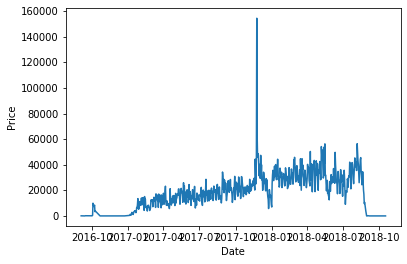

In [30]:
## Plot da relação entre data e preço. Poodemos observar um outlier

plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df4)

In [31]:
## Agora, vamos preencher as datas faltantes com vendas nulas

df4 = df4.asfreq(freq='1D', fill_value = 0)
df4

## Dropando valores nulos do início da série
df4 = df4.loc['2017-01-05':'2018-08-27']

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

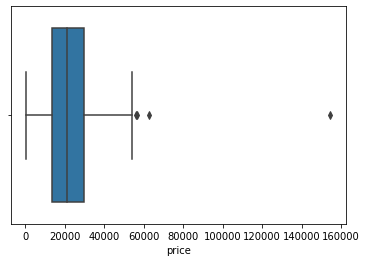

In [32]:
## Plotando o gráfico para identificar se ainda há presença de outliers

sns.boxplot(df4['price'])

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

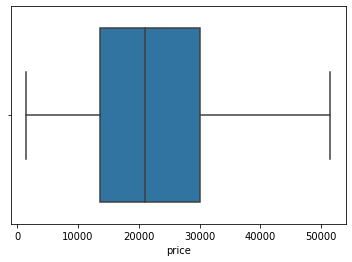

In [33]:
## Removendo outliers baseado no percentil de 0.99

upper_limit = df4['price'].quantile(0.99)
lower_limit = df4['price'].quantile(0.01)

df4['price'] = np.where((df4['price'] < lower_limit),
        lower_limit,
        np.where((df4['price'] > upper_limit),
        upper_limit,
        df4['price']))

## Plotando novamente o boxplot sem os outliers
sns.boxplot(df4['price'])

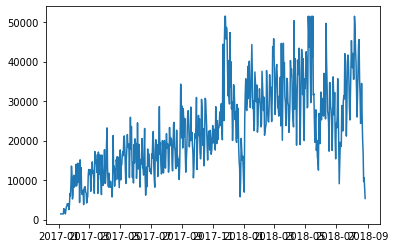

In [34]:
## Interpolando os valores nulos 

df4 = df4.asfreq(freq='1D', fill_value = 0)
df4.interpolate(inplace=True)

## Plotando a série tratada
plt.plot(df4)

In [35]:
## Dividindo dataset entre treino e teste (80/20)


import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

x = df4
df4_train, df4_test = train_test_split(x, train_size=480)

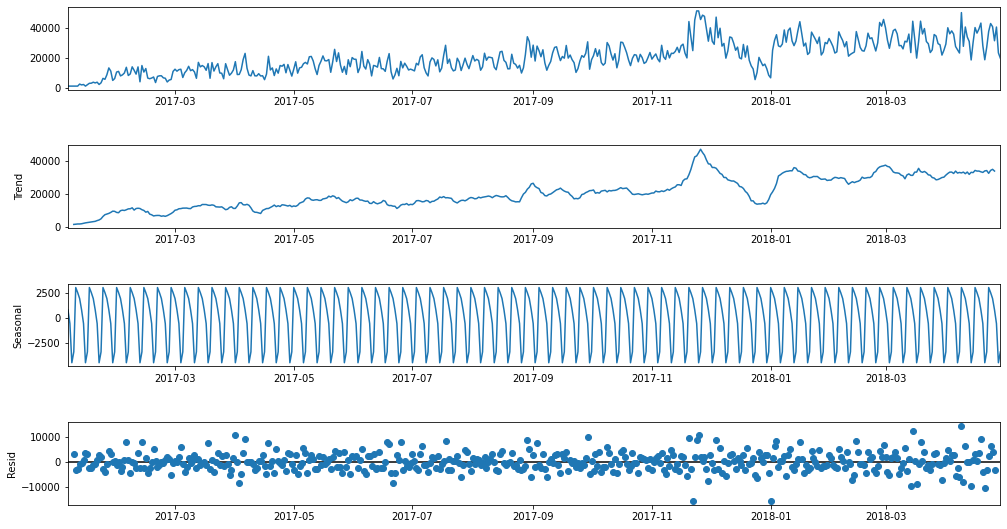

In [36]:
## Explorando tendência, sazonalidade e resíduos do dataset de treino

from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df4_train)
fig = season.plot();
fig.set_size_inches(16,8)

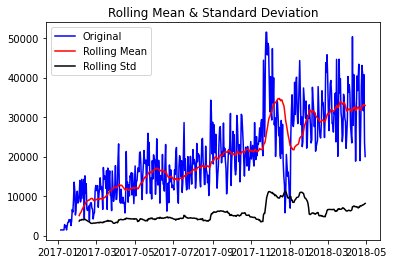

In [37]:
## Defasando para criar a média móvel e o desvio padrão em 30 dias

rolmean = df4_train.rolling(window= 30).mean()
rolstd = df4_train.rolling(window = 30).std()

## Plotando a média móvel

orig = plt.plot(df4_train, color='blue', label = 'Original')
mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [43]:
## Teste de Dickey-Fuller
def dickey_fuller(dickey_fuller_col):
    
    dickey_fuller_col.replace([np.inf, -np.inf], np.nan)
    dickey_fuller_col.dropna(inplace=True)
    
    from statsmodels.tsa.stattools import adfuller

    print ('Result of Fuller test:')

    dftest = adfuller(dickey_fuller_col, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', '#Number of observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]= value
    print("Dickey-Fuller test:\n")
    print(dfoutput)

    
## Dickey-fuller para o dataset original sem diferenciação

dickey_fuller(df4_train['price'])

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                   -2.308543
p-value                           0.169227
#Lags Used                       15.000000
#Number of observations Used    464.000000
Critical Value (1%)              -3.444522
Critical Value (5%)              -2.867789
Critical Value (10%)             -2.570099
dtype: float64


In [48]:
## Teste KPSS
def kpss(kpss_column):
    
    kpss_column.replace([np.inf, -np.inf], np.nan)
    kpss_column.dropna(inplace=True)
    
    from statsmodels.tsa.stattools import kpss

    kpss_input = kpss(kpss_column)
    kpss_test = pd.Series(kpss_input[0:3], index=['Teste Statistico KPSS','Valor-P','Lags Usados'])
    kpss_test = round(kpss_test,4)
    
    for key, value in kpss_input[3].items():
        kpss_test["Valores Críticos (%s)"%key] = value
    print("KPSS test:\n")
    print(kpss_test)

kpss(df4_train['price'])

KPSS test:

Teste Statistico KPSS       3.1895
Valor-P                     0.0100
Lags Usados                12.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


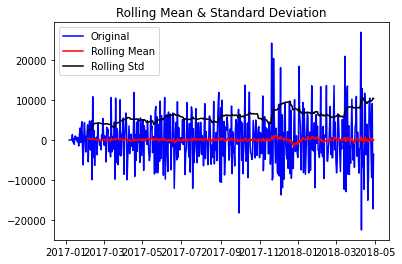

In [45]:
## Diferenciando o dataset original

df4_diff = df4_train.diff()

df4_rolmeandDiff = df4_diff.rolling(window= 30).mean()
df4_rolstdDiff = df4_diff.rolling(window = 30).std()


## Plotando o dataset diferenciado

orig = plt.plot(df4_diff, color='blue', label = 'Original')
mean = plt.plot(df4_rolmeandDiff, color='red', label = 'Rolling Mean')
std = plt.plot(df4_rolstdDiff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [46]:
## Dickey-fuller para o dataset com diferenciaçao

dickey_fuller(df4_diff['price'])

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


In [49]:
## KPSS para o dataset com diferenciação

kpss(df4_diff['price'])


KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [55]:
## Definindo funções ARIMA, RMSE e MAE

## ARIMA Modelo Original

def arima_model(arima_column, p, d, q):
    
    from statsmodels.tsa.arima.model import ARIMA
    arima = ARIMA(arima_column, freq='D', order = (p,d,q))
    result_AR = arima.fit()
    (result_AR.resid**2).mean()
    forecast = result_AR.forecast(steps=120)
    return result_AR, forecast
    

## Erro RMSE

def rmse(df_test, forecast):

    import math
    y_actual = df_test.squeeze()
    y_predicted = forecast.squeeze()

    MSE = 0

    for i in range(len(y_actual)):
        MSE += np.square(np.subtract(y_actual[i],y_predicted[i]))

    MSE = MSE/len(y_actual)
    RMSE = math.sqrt(MSE)
    print("Root Mean Square Error:\n")
    print(RMSE)
    
## Erro MAE

def mae(df_test, forecast):
    
    import math
    y_actual = df_test.squeeze()
    y_predicted = forecast.squeeze()

    MAE = 0

    for i in range(len(y_actual)):
        MAE += np.sqrt(np.power((np.subtract(y_actual[i],y_predicted[i])),2))

    MAE = MAE/len(y_actual)

    print("Mean Absolute Error:\n")
    print(MAE)

In [ ]:
############################################## ARIMA - Modelo Original #########################################################

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


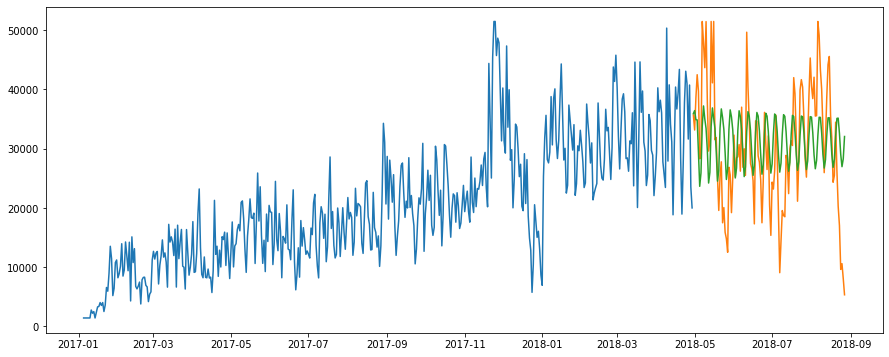

In [51]:
## ARIMA para o modelo original

df4_model, df4_forecast = arima_model(df4_train.price, 10,1,4)

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(df4_forecast)

In [57]:
## Erro RMSE
rmse(df4_test, df4_forecast)
print("\n")

## Erro MAE
mae(df4_test, df4_forecast)

Root Mean Square Error:

9201.27719132206


Mean Absolute Error:

7356.390513497618


In [63]:
def summary_model(df_test, forecast, df_col, model_resid):

    from statsmodels.stats.stattools import durbin_watson
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from scipy.stats import kstest
    from scipy.stats import jarque_bera
    from statsmodels.stats.diagnostic import het_arch
    from matplotlib.pyplot import scatter
    
    ## RMSE
    
    rmse(df_test, forecast)
    print("\n")
    
    ## MAE
    
    mae(df_test, forecast)
    print("\n")
    ## Dickey-Fuller
    
    dickey_fuller(df_col)
    print("\n")
    
    ## KPSS
    
    kpss(df_col)
    print("\n")
    
    ## Ljung-Box
    
    print("Ljung-Box test:\n")
    print(acorr_ljungbox(model_resid, lags=[30]))
    print("\n")
    
    ## Durbin-Watson
    
    print("Durbin-Watson test:\n")
    print(durbin_watson(model_resid))
    print("\n")
    
    ## KSTest
    
    print("KS test:\n")
    print(kstest(model_resid, 'norm'))
    print("\n")
    
    ## Jarque-Bera
    
    print("Jarque-bera test:\n")
    print(jarque_bera(model_resid))
    print("\n")
    
    ## ARCH-Test
    print("ARCH test:\n")
    print(het_arch(model_resid, nlags=30, store=True, ddof=0))
    print("\n")
    
summary_model(df4_test, df4_forecast, df4_diff['price'], df4_model.resid)

Root Mean Square Error:

9201.27719132206


Mean Absolute Error:

7356.390513497618


Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


Ljung-Box test:

      lb_stat  lb_pvalue
30  34.153636   0.274732


Durbin-Watson test:

1.9385105313676767


KS test:

KstestResult(statistic=0.5125, pvalue=1.5683853096428398e-117)


Jarque-bera test:

Jarque_beraResult(statistic=41.3825950972485, pvalue=1.0324

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


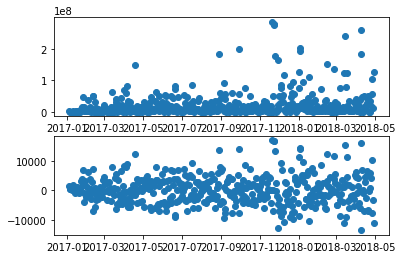

In [68]:
## Plot Erro quadrático médio

def plot_error(df_model, df_train_index):
    
    ## Plot erro quadrático
    
    res = df_model.resid**2

    from matplotlib.pyplot import scatter
    plt.subplot(2,1,1)
    scatter(df_train_index, res)

    ## Plot Erro

    from matplotlib.pyplot import scatter
    plt.subplot(2,1,2)
    scatter(df_train_index, df_model.resid)
    
plot_error(df4_model, df4_train.index)

In [ ]:
################################################### ARIMA - Transformação Logarítmica ##########################################

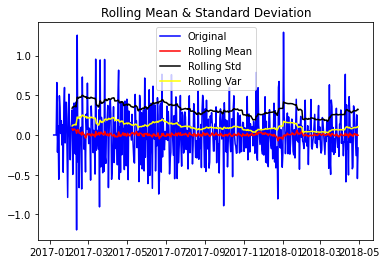

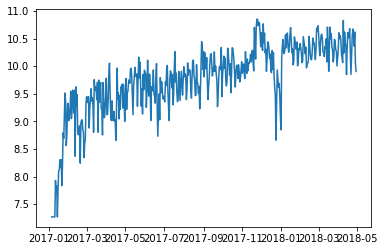

In [74]:
## ARIMA com transformação logarítmica

##Transformando o dataset

df4_log_train = np.log(df4_train)
df4_log_test = np.log(df4_test)

df4_log_train_diff = df4_log_train.diff()

rolmeandDiffLog = df4_log_train_diff.rolling(window= 30).mean()
rolstdDiffLog = df4_log_train_diff.rolling(window = 30).std()
rolvarDiffLog = df4_log_train_diff.rolling(window = 30).var()

## Plotando o dataset transformado e diferenciado

orig = plt.plot(df4_log_train_diff, color='blue', label = 'Original')
mean = plt.plot(rolmeandDiffLog, color='red', label = 'Rolling Mean')
std = plt.plot(rolstdDiffLog, color='black', label = 'Rolling Std')
std = plt.plot(rolvarDiffLog, color='yellow', label = 'Rolling Var')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

plt.plot(df4_log_train)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


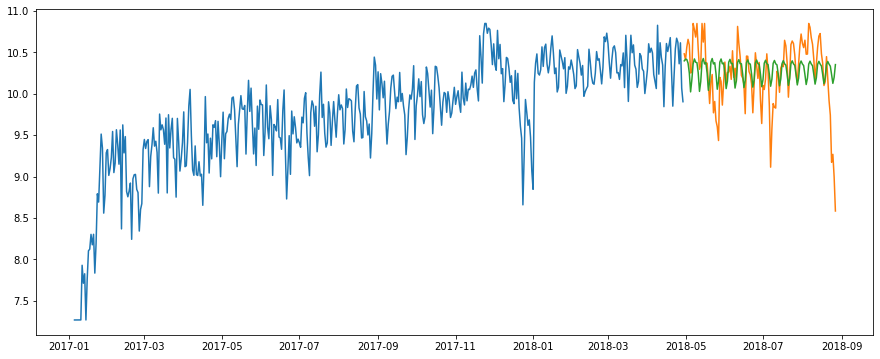

In [75]:
## ARIMA para o modelo com transformação logarítmica

df4_log_model, df4_log_forecast = arima_model(df4_log_train.price, 13 ,1 ,8)

plt.figure(figsize=(15, 6))
plt.plot(df4_log_train.price)
plt.plot(df4_log_test)
plt.plot(df4_log_forecast)

In [76]:
## Analisando resultados

forecast_log = np.exp(df4_log_forecast)
df4_log_test = np.exp(df4_log_test)

summary_model(df4_log_test, forecast_log, df4_log_train_diff['price'], df4_log_model.resid)

Root Mean Square Error:

9180.061052748213


Mean Absolute Error:

7370.351016863287


Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.146155e+00
p-value                         7.758427e-08
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.4192
Valor-P                      0.0689
Lags Usados                233.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


Ljung-Box test:

      lb_stat  lb_pvalue
30  12.035588    0.99856


Durbin-Watson test:

1.3548775308931338


KS test:

KstestResult(statistic=0.3011093684662918, pvalue=4.244224522925074e-39)


Jarque-bera test:

Jarque_beraResult(statistic=677593.587363

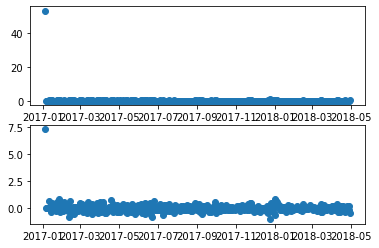

In [77]:
## Verificando heterocedasticidade plotando os erros

plot_error(df4_log_model, df4_log_train.index)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

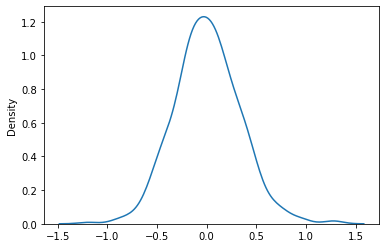

In [119]:
## Avaliar box-cox

import numpy as np 
from scipy.stats import boxcox 
import seaborn as sns 

sns.distplot(df4_log_train_diff, hist=False, kde=True) 

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='boxcox', ylabel='Density'>

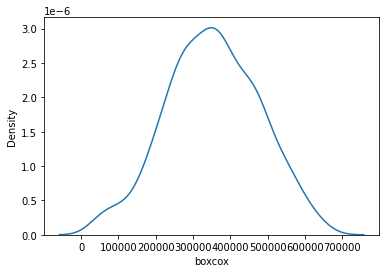

In [79]:
## Transformação box-cox

df4_log_train['boxcox'], best_lambda = boxcox(df4_log_train['price']) 

sns.distplot(df4_log_train['boxcox'], hist=False, kde=True)

In [ ]:
################################################ SARIMA - Modelo Original #####################################################

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


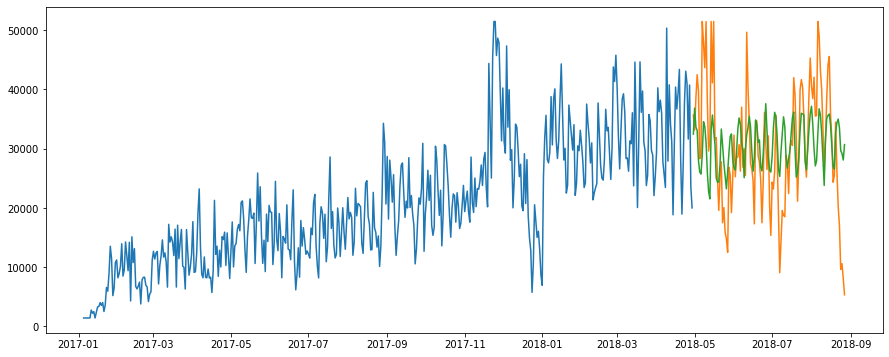

In [82]:
def sarima_model(sarima_column, p, d, q, P, D, Q):
    
    import statsmodels.api as sm
    from statsmodels.tsa.arima.model import ARIMA
    
    result_SAR = sm.tsa.statespace.SARIMAX(sarima_column, freq = 'D', order = (p ,d, q), seasonal_order=(P, D, Q, 30)).fit()
    forecast = result_SAR.forecast(steps=120)
    return result_SAR, forecast

## Sarima para o modelo original

df4_sarima_model, df4_sarima_forecast = sarima_model(df4_train.price, 10,1 ,4, 6, 1, 2)

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(df4_sarima_forecast)

## Resultados:

## RMSE: 9819,72 para order = (10 ,1, 4),seasonal_order=(1, 1, 1, 30)
## RMSE: 9984.157432164373 para order = (10 ,1, 4),seasonal_order=(1, 1, 2, 30)
## RMSE: 9991.40202239523 para order = (10 ,1, 4),seasonal_order=(2, 1, 1, 30)
## RMSE: 9878.068506130081 para order = (10 ,1, 4),seasonal_order=(2, 1, 2, 30)
## RMSE: 9569.281540521444 para order = (10 ,1, 4),seasonal_order=(3, 1, 2, 30)
## RMSE: 9321.300672167628 para order = (10 ,1, 4),seasonal_order=(4, 1, 2, 30)
## RMSE: 9317.747451897061 para order = (10 ,1, 4),seasonal_order=(5, 1, 2, 30)
## RMSE: 9361.899167234831 para order = (10 ,1, 4),seasonal_order=(5, 1, 3, 30)
## RMSE: 9103.835504076142 para order = (10 ,1, 4),seasonal_order=(6, 1, 2, 30) 
## RMSE: 9277.125964937486 para order = (10 ,1, 4), seasonal_order=(7, 1, 2, 30)
## RMSE: 9305.669234206498 para order = (10 ,1, 4), seasonal_order=(6, 1, 3, 30)
## RMSE: 9368.528186274874 para order = (10 ,1, 4),seasonal_order=(6, 1, 4, 30)
## RMSE: 9241.073158681867 para order = (10 ,1, 4),seasonal_order=(7, 1, 3, 30)
## RMSE: 9290.071823415343 para order = (10 ,1, 4),seasonal_order=(8, 1, 3, 30)

In [83]:
## Summary do modelo

summary_model(df4_test, df4_sarima_forecast, df4_diff['price'], df4_sarima_model.resid)

Root Mean Square Error:

9103.835504076142


Mean Absolute Error:

7106.68563770809


Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.615837e+00
p-value                         6.210773e-09
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS       0.1895
Valor-P                     0.1000
Lags Usados                78.0000
Valores Críticos (10%)      0.3470
Valores Críticos (5%)       0.4630
Valores Críticos (2.5%)     0.5740
Valores Críticos (1%)       0.7390
dtype: float64


Ljung-Box test:

      lb_stat  lb_pvalue
30  48.253038   0.018703


Durbin-Watson test:

1.9607185448919808


KS test:



C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


KstestResult(statistic=0.525, pvalue=8.976947935169697e-124)


Jarque-bera test:

Jarque_beraResult(statistic=58.66638273864016, pvalue=1.822986206434507e-13)


ARCH test:

(67.9511217242518, 9.081539859537333e-05, 2.550876301917829, 2.1673844482050573e-05, <statsmodels.stats.diagnostic.ResultsStore object at 0x00000002A88F7910>)




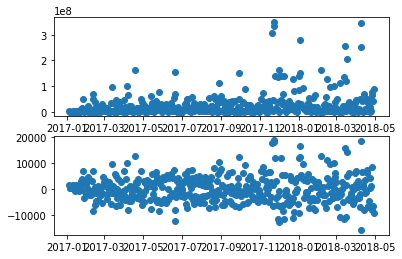

In [84]:
## Analisando resultados

plot_error(df4_sarima_model, df4_train.index)

In [ ]:
############################################## SARIMA - Transformação Logarítmica #############################################

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


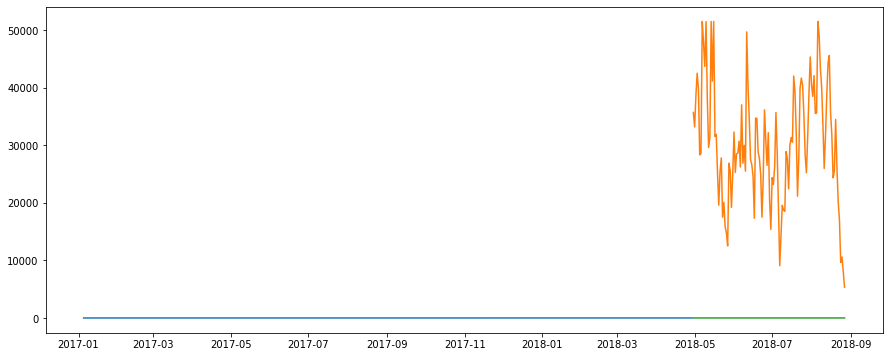

In [86]:
## Sarima para o modelo com transformção logarítmica

df4_log_sarima_model, df4_log_sarima_forecast = sarima_model(df4_log_train.price, 10 ,1 ,4, 6, 1, 2)

df4_log_test = np.log(df4_test)

plt.figure(figsize=(15, 6))
plt.plot(df4_log_train.price)
plt.plot(df4_log_test)
plt.plot(df4_log_sarima_forecast)

## Resultados:

## RMSE: 9764.957263578564 order = (10 ,1, 4),seasonal_order=(6, 1, 2, 30)
## RMSE: 11509.113274808042 order = (13 ,1, 8),seasonal_order=(6, 1, 2, 30)
## RMSE: 18838.95621248338  order = (13 ,1, 8),seasonal_order=(6, 1, 3, 30)
## RMSE: 15353.766193912934 order = (10 ,1, 4),seasonal_order=(6, 1, 3, 30)
## RMSE: 9950.505437483987 order = (10 ,1, 4),seasonal_order=(7, 1, 2, 30)
## RMSE: 15281.772681373654 order = (10 ,1, 4),seasonal_order=(5, 1, 2, 30)
## RMSE: 9770.653750812133 order = (10 ,1, 4),seasonal_order=(8, 1, 2, 30))
## RMSE: 10020.933488790599 order = (10 ,1, 4),seasonal_order=(9, 1, 2, 30)
## RMSE: 11173.787394506411 order = (1 ,1, 1),seasonal_order=(6, 1, 2, 30)

In [94]:
## Analisando resultados

forecast_log_sarima = np.exp(df4_log_sarima_forecast)
df4_log_test = np.exp(df4_log_test)

summary_model(df4_log_test, forecast_log_sarima, df4_log_train_diff['price'], df4_log_sarima_model.resid)

Root Mean Square Error:

9764.957263578564


Mean Absolute Error:

7666.960497398232


Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.146155e+00
p-value                         7.758427e-08
#Lags Used                      1.500000e+01
#Number of observations Used    4.630000e+02
Critical Value (1%)            -3.444553e+00
Critical Value (5%)            -2.867803e+00
Critical Value (10%)           -2.570106e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.4192
Valor-P                      0.0689
Lags Usados                233.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


Ljung-Box test:

      lb_stat  lb_pvalue
30  47.985608   0.019891


Durbin-Watson test:

1.4572591726990294


KS test:

KstestResult(statistic=0.2859022549433855, pvalue=3.2042053808655585e-35)


Jarque-bera test:

Jarque_beraResult(statistic=289073.00459

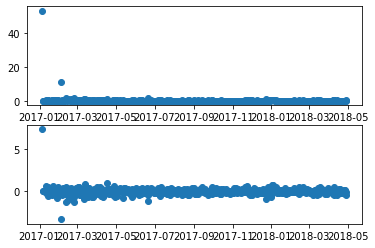

In [95]:
## Verificando heterocedasticidade plotando os erros

plot_error(df4_log_sarima_model, df4_log_train.index)

In [96]:
################################################## SARIMA - Notas 4 e 5 ######################################################

C:\Users\valeria\AppData\Local\Temp\ipykernel_6180\2545891044.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['order_purchase_timestamp'] = pd.to_datetime(df7['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
C:\Users\valeria\AppData\Local\Temp\ipykernel_6180\2545891044.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['order_purchase_timestamp'] = df7['order_purchase_timestamp'].dt.date


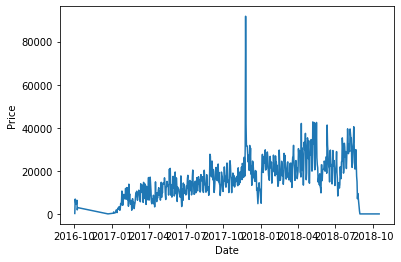

In [97]:
## Criando o dataset

df6 = {}
df6 = pd.DataFrame().assign(order_purchase_timestamp=df['order_purchase_timestamp'], price=df['price'], review_score=df['review_score'])
df6.head()

df7 = df6[df6['review_score']>3]

## Transformando de datetime para date

df7['order_purchase_timestamp'] = pd.to_datetime(df7['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
df7['order_purchase_timestamp'].dtype

df7['order_purchase_timestamp'] = df7['order_purchase_timestamp'].dt.date

## Agregando o preço por data

df7 = df7.groupby("order_purchase_timestamp").price.sum()
df7 = df7.to_frame()

## Plot da relação entre data e preço. Poodemos observar um outlier

plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df7)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

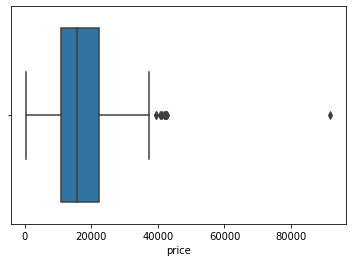

In [98]:
## Preenchendo as datas faltantes com vendas nulas

df7 = df7.asfreq(freq='1D', fill_value = 0)
df7

## Dropando valores nulos do início da série
df7 = df7.loc['2017-01-05':'2018-08-27']

import seaborn as sns
sns.boxplot(df7['price'])


C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

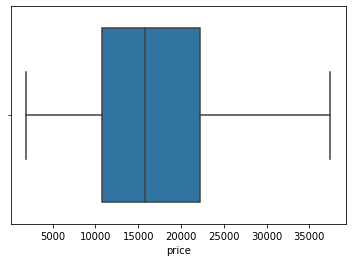

In [99]:
## Aqui, será utilizado percentil de 0.98 para remover todos os outliers

upper_limit = df7['price'].quantile(0.98)
lower_limit = df7['price'].quantile(0.02)

df7['price'] = np.where((df7['price'] < lower_limit),
        lower_limit,
        np.where((df7['price'] > upper_limit),
        upper_limit,
        df7['price']))

sns.boxplot(df7['price'])

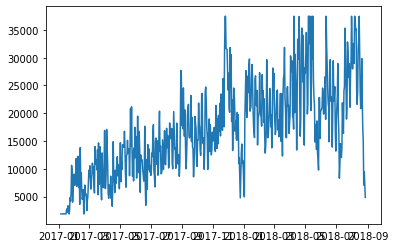

In [100]:
## Plotando a série tratada

df7 = df7.asfreq(freq='1D', fill_value = 0)

df7.interpolate(inplace=True)

plt.plot(df7)

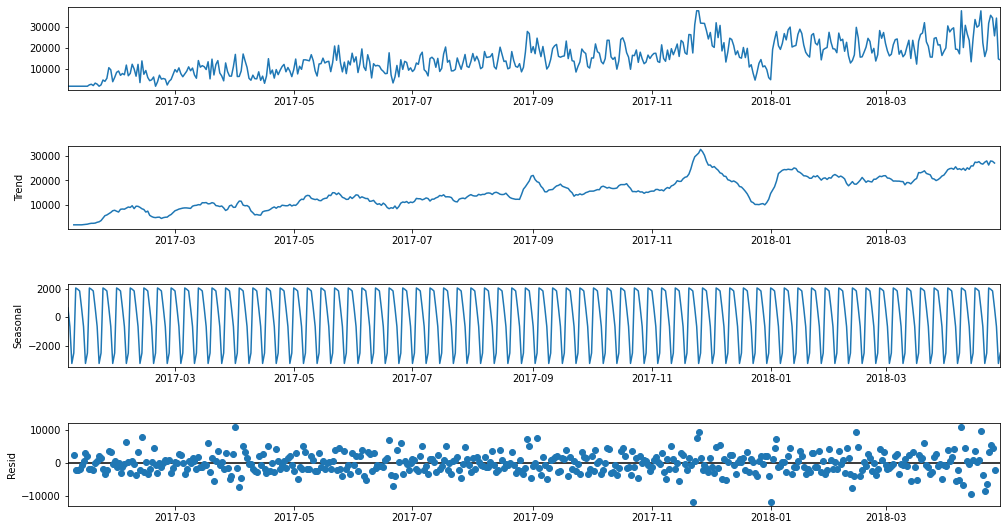

In [101]:
## Dividindo dataset entre treino e teste


import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Dividindo o dataset entre treino e teste
x = df7
df7_train, df7_test = train_test_split(x, train_size=480)

## Plotando tendência, sazonalidade e resíduos

from statsmodels.tsa.seasonal import seasonal_decompose

season = seasonal_decompose(df7_train)
fig = season.plot();
fig.set_size_inches(16,8)

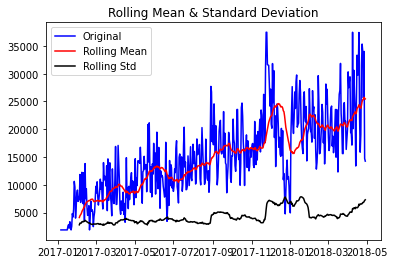

In [102]:
## Defasando para criar a média móvel e o desvio padrão em 30 dias

rolmean = df7_train.rolling(window= 30).mean()
rolstd = df7_train.rolling(window = 30).std()

## Plotando a média móvel

orig = plt.plot(df7_train, color='blue', label = 'Original')
mean = plt.plot(rolmean, color='red', label = 'Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [103]:
## Teste de Dickey-Fuller

dickey_fuller(df7_train['price'])

Result of Fuller test:
Dickey-Fuller test:

Test Statistic                   -2.404564
p-value                           0.140452
#Lags Used                       15.000000
#Number of observations Used    464.000000
Critical Value (1%)              -3.444522
Critical Value (5%)              -2.867789
Critical Value (10%)             -2.570099
dtype: float64


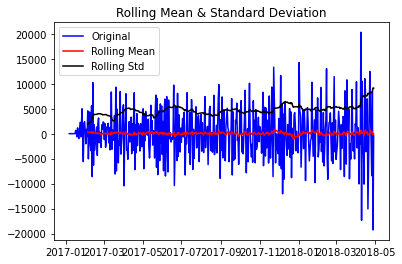

In [104]:
##Diferenciando a série

df7_diff = df7_train.diff()

df7_rolmeandDiff = df7_diff.rolling(window= 30).mean()
df7_rolstdDiff = df7_diff.rolling(window = 30).std()


## Plotando a diferenciação

orig = plt.plot(df7_diff, color='blue', label = 'Original')
mean = plt.plot(df7_rolmeandDiff, color='red', label = 'Rolling Mean')
std = plt.plot(df7_rolstdDiff, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


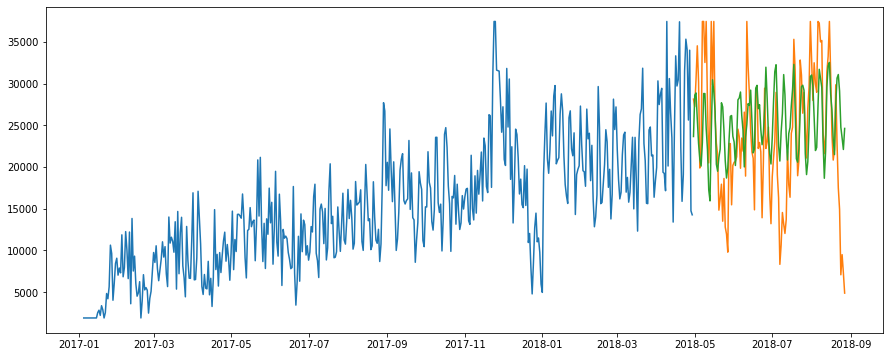

In [106]:
## Sarima para o modelo original

df7_sarima_model, df7_sarima_forecast = sarima_model(df7_train.price, 10 ,1 ,4, 6, 1, 2)

plt.figure(figsize=(15, 6))
plt.plot(df7_train.price)
plt.plot(df7_test)
plt.plot(df7_sarima_forecast)

In [107]:
## Summary do modelo

summary_model(df7_test, df7_sarima_forecast, df7_diff['price'], df7_sarima_model.resid)

Root Mean Square Error:

7268.142949863834


Mean Absolute Error:

5775.78932783638


Result of Fuller test:
Dickey-Fuller test:

Test Statistic                 -6.340439e+00
p-value                         2.763242e-08
#Lags Used                      1.400000e+01
#Number of observations Used    4.640000e+02
Critical Value (1%)            -3.444522e+00
Critical Value (5%)            -2.867789e+00
Critical Value (10%)           -2.570099e+00
dtype: float64


KPSS test:

Teste Statistico KPSS        0.2928
Valor-P                      0.1000
Lags Usados                149.0000
Valores Críticos (10%)       0.3470
Valores Críticos (5%)        0.4630
Valores Críticos (2.5%)      0.5740
Valores Críticos (1%)        0.7390
dtype: float64


Ljung-Box test:

      lb_stat  lb_pvalue
30  45.443271   0.035086


Durbin-Watson test:

1.9936266860326883


KS test:

KstestResult(statistic=0.512499999973858, pvalue=1.5683853560264572e-117)


Jarque-bera test:

Jarque_beraResult(statistic=31.5921151155

C:\Users\valeria\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


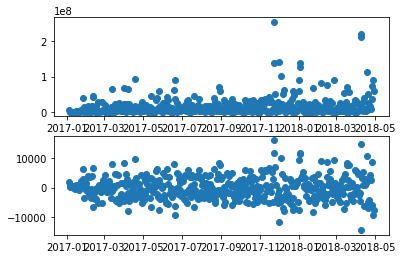

In [108]:
## Analisando resultados

plot_error(df7_sarima_model, df7_train.index)

In [ ]:
############################### Comparando resultados para notas boas/ruins e notas boas ######################################

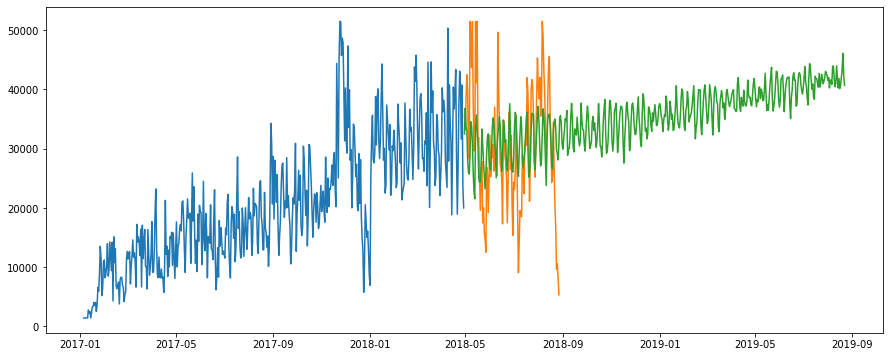

In [114]:
## Forecast para notas boas e ruins

forecast_all = df4_sarima_model.forecast(steps=480)

forecast_all = forecast_all.loc['2018-04-30':'2019-08-22']

plt.figure(figsize=(15, 6))
plt.plot(df4_train.price)
plt.plot(df4_test)
plt.plot(forecast_all)

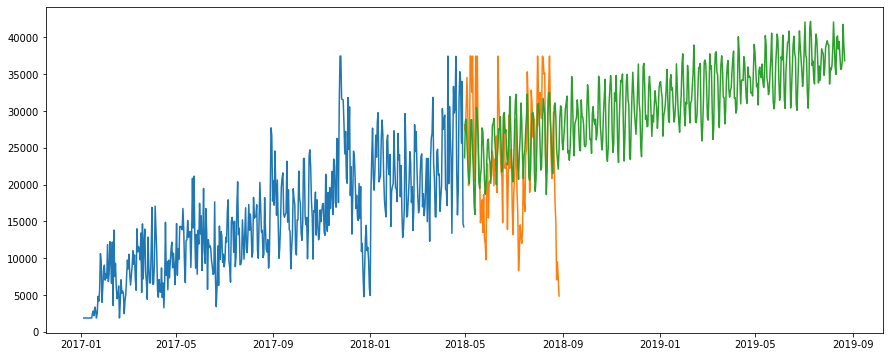

In [115]:
##Forecast para notas boas

forecast_best_scores = df7_sarima_model.forecast(steps=480)

forecast_best_scores = forecast_best_scores.loc['2018-04-30':'2019-08-22']

plt.figure(figsize=(15, 6))
plt.plot(df7_train.price)
plt.plot(df7_test)
plt.plot(forecast_best_scores)

In [111]:
## Soma da receita para notas boas e ruins

forecast_all.sum()

13381690.04969742

In [112]:
## Soma da receita para notas boas

forecast_best_scores.sum()

11805674.776975483